<a href="https://colab.research.google.com/github/ykitaguchi77/GAN/blob/master/Toony_Yourself.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Toony Yourself**

implementation: http://cedro3.com/ai/toonify-yourself/#comment-869

original: 

In [ ]:
#割当てGPUとメモリの確認
#TESLA V100なら大当たり、P100ならOK（標準）、K80はハズレ（無料版相当）
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [2]:
#StyleGANをGit clone
%tensorflow_version 1.x
!git clone https://github.com/justinpinkney/stylegan2

%cd stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run
 
# フォルダーの作成
!mkdir aligned
!mkdir generated

TensorFlow 1.x selected.
fatal: destination path 'stylegan2' already exists and is not an empty directory.
/content/stylegan2
CPU says hello.
GPU says hello.
mkdir: cannot create directory ‘aligned’: File exists
mkdir: cannot create directory ‘generated’: File exists


In [5]:
# ffhqモデル(Baseモデル)とblendedモデルのダウンロード
import pretrained_networks
import gdown

 
# use my copy of the blended model to save Doron's download bandwidth
# get the original here https://mega.nz/folder/OtllzJwa#C947mCCdEfMCRTWnDcs4qw
#blended_url = "https://drive.google.com/uc?id=1H73TfV5gQ9ot7slSed_l-lim9X7pMRiU"
blended_url = "https://drive.google.com/uc?id=1BRqqHWk_4BjNHLXTrpHkoxmZhGw3CU59" 
ffhq_url = "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"

#エラーがでてうまくいかないので、ダイレクトにダウンロードすることにする 
gdown.download(blended_url, quiet=False)
gdown.download(ffhq_url, quiet=False)
_, _, Gs_blended = pretrained_networks.load_networks("/content/stylegan2/ffhq-cartoon-blended-64.pkl")
_, _, Gs = pretrained_networks.load_networks("/content/stylegan2/stylegan2-ffhq-config-f.pkl")


Downloading...
From: https://drive.google.com/uc?id=1BRqqHWk_4BjNHLXTrpHkoxmZhGw3CU59
To: /content/stylegan2/ffhq-cartoon-blended-64.pkl
100%|██████████| 382M/382M [00:02<00:00, 170MB/s]
Downloading...
From: http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl
To: /content/stylegan2/stylegan2-ffhq-config-f.pkl
100%|██████████| 382M/382M [00:02<00:00, 179MB/s]


Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


#**必要な関数を定義**

In [6]:
# 画像表示
import matplotlib.pyplot as plt
from PIL import Image
import glob
import numpy as np

def display_pic(folder):
    fig = plt.figure(figsize=(30, 40))
    files = glob.glob(folder)
    files.sort()
    images=[]
    for i in range(len(files)):
        img = Image.open(files[i])    
        images = np.asarray(img)
        ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
        image_plt = np.array(images)
        ax.imshow(image_plt)
        ax.set_xlabel(str(i), fontsize=20)               
    plt.show()
    plt.close()  

# 潜在変数(latents)から生成した画像を表示
import PIL.Image
def display(latents):
    
    synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=8)
  
    fig = plt.figure(figsize=(30, 40))   
    for i in range(len(latents)):
        vec = latents[i].reshape(1,18,512)
        images =  Gs_blended.components.synthesis.run(vec, randomize_noise=False, **synthesis_kwargs)  
        images = images.transpose((0,2,3,1))     
        PIL.Image.fromarray(images[0], 'RGB')   
        ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
        image_plt = np.array(images[0])
        ax.imshow(image_plt)
        ax.set_xlabel(str(i), fontsize=20)               
    plt.show()
    plt.close()

# 潜在変数(latents)の順番を指定して、トランジションのGIFを作成する
import os

def generate_gif(latents, idx):

    synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=8)

    image_gif = []
    os.makedirs('my/gif', exist_ok=True)
    for j in range(len(idx)-1):
        for i in range(20):
            latent = latents[idx[j]]+(latents[idx[j+1]]-latents[idx[j]])*i/19
            latent = latent.reshape(1, 18, 512)
            images =  Gs_blended.components.synthesis.run(latent, randomize_noise=False, **synthesis_kwargs) 
            images = images.transpose((0,2,3,1)) 
            image_one = PIL.Image.fromarray(images[0], 'RGB')
            image_gif.append(image_one.resize((256,256))) 

    image_gif[0].save('./my/gif/anime.gif', save_all=True, append_images=image_gif[1:],
                      duration=100, loop=0) 

In [7]:
# サンプル写真のダウンロードと整形
import os 
import bz2
import shutil
import requests
import urllib.request


# rawフォルダを作成
try: 
    shutil.rmtree("/content/stylegan2/raw")
    print("directory presents")
    print("")
except:
    pass
os.makedirs("/content/stylegan2/raw", exist_ok=True)


#Webから画像をダウンロードしてrawフォルダに格納
url = "https://images.unsplash.com/photo-1597223557154-721c1cecc4b0?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxzZWFyY2h8Mnx8aHVtYW4lMjBmYWNlfGVufDB8fDB8fA%3D%3D&w=1000&q=80"
file_name = "/content/stylegan2/raw/sample.jpg"

response = requests.get(url)
image = response.content
with open(file_name, "wb") as aaa:
    aaa.write(image)

#styleGANのモジュールを用いて画像のアラインメントを行う
!python align_images.py raw aligned

directory presents



Loading networks from "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "sample_01.png"...


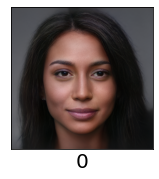

In [8]:
# 顔画像の潜在変数を求める 
!python project_images.py --num-steps 500 aligned generated
display_pic('./generated/*.png')

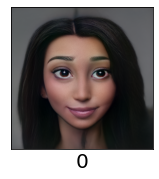

In [10]:
# 潜在変数wからアニメ画像を生成する
import numpy as np
from PIL import Image
import dnnlib
import dnnlib.tflib as tflib
from pathlib import Path

latent_dir = Path("generated")
latents = sorted(latent_dir.glob("*.npy"))

for i, latent_file in enumerate(latents):
  latent = np.load(latent_file)
  latent = np.expand_dims(latent,axis=0)
  synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=8)
  images = Gs_blended.components.synthesis.run(latent, randomize_noise=False, **synthesis_kwargs)
  Image.fromarray(images.transpose((0,2,3,1))[0], 'RGB').save(latent_file.parent / (f"{latent_file.stem}-toon.jpg"))
  
  if i == 0:
    latents = latent
  else:
    latents = np.concatenate([latents, latent])  

# 潜在変数(latents)から生成した画像を表示する
display(latents)

In [ ]:
# 潜在変数(latents)の順番を指定して、トランジションGIFを作成する
from IPython.display import Image
generate_gif(latents,[0,1,2,0])
Image('./my/gif/anime.gif', format='png')